<a href="https://colab.research.google.com/github/nanaho-mu/musicgenerate/blob/main/musicgeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

from PIL import Image
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import math
from torch.autograd import Variable
from torchvision.utils import save_image
import cv2
import sys
import copy

import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dir_path, input_size):
        super().__init__()
        
        self.dir_path = dir_path
        self.input_size = input_size
        self.transform = transforms.Compose([transforms.ToTensor()]) 
        self.image_paths = [str(p) for p in Path(self.dir_path).glob("**/*.bmp")]
        self.len = len(self.image_paths)

        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        p = self.image_paths[index]
        
        # 入力
        image = Image.open(p)
        image = image.resize(self.input_size)
        image = self.transform(image)
        
        # ラベル (0: ants, 1: bees)
        label = p.split("/")[2]
        label = 1 if label == "bees" else 0
        
        return image, label
        
    




transform=transforms.ToTensor(),  # Tensor化
save_img = True 
train_dataset = MyDataset("/content/train", (749,115))
valid_dataset = MyDataset("/content/test", (749,115))

dataloader_train=torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
dataloader_valid=torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)
image, label = train_dataset[0]

print(image.size(), label) 



torch.Size([3, 115, 749]) 0


In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim):
      super(VAE, self).__init__()
      self.dense_enc1 = nn.Linear((115*749*3), 400) 
      self.dense_enc2 = nn.Linear(400, 400) 
      self.dense_encmean = nn.Linear(400, z_dim) 
      self.dense_encvar = nn.Linear(400, z_dim) 
      self.dense_dec1 = nn.Linear(z_dim, 400) 
      self.dense_dec2 = nn.Linear(400, 400) 
      self.dense_dec3 = nn.Linear(400, 115*749*3) 

    def _encoder(self, x):
      x = F.relu(self.dense_enc1(x)) 
      x = F.relu(self.dense_enc2(x)) 
      mean = self.dense_encmean(x) 
      var = F.softplus(self.dense_encvar(x)) 
      return mean, var

    def _sample_z(self, mean, var):
      epsilon = torch.randn(mean.shape).to(device) 
      return mean + torch.sqrt(var) * epsilon 

    def _decoder(self, z):
      x = F.relu(self.dense_dec1(z)) 
      x = F.relu(self.dense_dec2(x)) 
      x = torch.sigmoid(self.dense_dec3(x)) 
      return x

    def forward(self, x): 
      mean, var = self._encoder(x) 
      z = self._sample_z(mean, var) 
      x = self._decoder(z) 
      return x, z 

    def loss(self, x): #損出関数を定義
      delta = 1e-7
      mean, var = self._encoder(x) 
      KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var + delta) - mean**2 - var)) 
      z = self._sample_z(mean, var) 
      y = self._decoder(z) 
      #再構築ロスとしてバイナリクロスエントロピー誤差の平均値を求める
      reconstruction = torch.mean(torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta)))
      lower_bound = [-KL, reconstruction]                                      
      return -sum(lower_bound) 

    def loss_only_reconstruction(self, x):
      delta = 1e-7
      mean, var = self._encoder(x)
      z = self._sample_z(mean, var) 
      y = self._decoder(z) 
      #再構築ロスとしてバイナリクロスエントロピー誤差の平均値を求める
      re = torch.mean(torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta)))
      return re #再構成ロスのみ返す
    
    def loss_1(self, x):
      delta = 1e-7
      mean, var = self._encoder(x)
      reg_loss = 0.5 * torch.mean(torch.sum(1 + torch.log(var + delta) - mean**2 - var)) #正則誤差
      z = self._sample_z(mean, var)
      y = self._decoder(z)
      rec_loss = torch.mean(torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))) #再構成誤差
      # reg_loss = [-KL, reconstruction]                                      
      return (rec_loss, reg_loss)



In [ ]:
# batch_size = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 100


In [ ]:
model = VAE(8).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for i in range(100):
  rec_error_record = []
  reg_error_record = []
  total_error_record = []
  for x,t in dataloader_train:
    x = x.to(device)
    x = x.view(-1,115*749*3)
    y = model(x)
    lrec, lreg = model.loss_1(x)
    loss = -(lrec + lreg)
    if torch.isnan(loss):
      model = prev_model
      optimizer = torch.optim.Adam(model.parameters())
      optimizer.load_state_dict(prev_optimizer.state_dict())
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
    
    model.zero_grad()
    loss.backward()
    optimizer.step()
    rec_error_record.append(lrec.cpu().detach().numpy())
    reg_error_record.append(lreg.cpu().detach().numpy())
    total_error_record.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss_total: {}".format(i, np.average(total_error_record)), "EPOCH: {} loss_rec: {}".format(i, np.average(rec_error_record)), "EPOCH: {} loss_reg: {}".format(i, np.average(reg_error_record)))
torch.save(model.state_dict(),"model.pth")

EPOCH: 0 loss_total: 64856.89453125 EPOCH: 0 loss_rec: -64760.7734375 EPOCH: 0 loss_reg: -96.12454986572266
EPOCH: 1 loss_total: 58630.28515625 EPOCH: 1 loss_rec: -58578.078125 EPOCH: 1 loss_reg: -52.213470458984375
EPOCH: 2 loss_total: 58194.1640625 EPOCH: 2 loss_rec: -58135.08984375 EPOCH: 2 loss_reg: -59.07061004638672
EPOCH: 3 loss_total: 57770.45703125 EPOCH: 3 loss_rec: -57706.5859375 EPOCH: 3 loss_reg: -63.87329864501953
EPOCH: 4 loss_total: 57268.51171875 EPOCH: 4 loss_rec: -57200.7109375 EPOCH: 4 loss_reg: -67.7964859008789
EPOCH: 5 loss_total: 57321.515625 EPOCH: 5 loss_rec: -57251.62890625 EPOCH: 5 loss_reg: -69.88414764404297
EPOCH: 6 loss_total: 56916.97265625 EPOCH: 6 loss_rec: -56845.23046875 EPOCH: 6 loss_reg: -71.744140625
EPOCH: 7 loss_total: 57013.7890625 EPOCH: 7 loss_rec: -56939.43359375 EPOCH: 7 loss_reg: -74.35340881347656
EPOCH: 8 loss_total: 57009.84375 EPOCH: 8 loss_rec: -56936.76953125 EPOCH: 8 loss_reg: -73.07471466064453
EPOCH: 9 loss_total: 56817.98046875 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


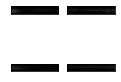

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3)) 


model.eval() 
zs = []
for x in dataloader_train: 
  images=x[0].view(-1,3,115,749)
  images = np.transpose(images.detach().cpu().numpy(), (0,2,3,1))
  for i, im in enumerate(images[:2]):
    pil_img = Image.fromarray(np.uint8(im * 255))
    pil_img.save("/content/result/train_ex_img_{}.bmp".format(i))
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, "gray")
  x = x[0].to(device)
  x = x.view(-1,115*749*3)
  y, z = model(x) 
  zs.append(z)
  y = y.view(-1, 3, 115, 749) 
  y=np.transpose(y.detach().cpu().numpy(), (0,2,3,1))
  for i, im in enumerate(y[:2]):
    pil_img.save("/content/result/train_af_img_{}.bmp".format(i))
    ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
    ax.imshow(im, "gray")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


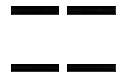

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3)) 


model.eval()
zs = []
for x in dataloader_valid: 
  images=x[0].view(-1,3,115,749)
  images = np.transpose(images.detach().cpu().numpy(), (0,2,3,1))
  for i, im in enumerate(images[:2]):
    pil_img = Image.fromarray((im * 255).astype(np.uint8))
    pil_img.save("/content/result/valid_ex_img_{}.bmp".format(i))
    ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, "gray")
  x = x[0].to(device)
  x = x.view(-1,115*749*3)
  y, z = model(x) 
  zs.append(z)
  y = y.view(-1, 3, 115, 749)
  y=np.transpose(y.detach().cpu().numpy(), (0,2,3,1))
  for i, im in enumerate(y[:2]):
    pil_img = Image.fromarray(np.uint8(im * 255))
    pil_img.save("/content/result/valid_af_img_{}.bmp".format(i))
    ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
    ax.imshow(im, "gray")

In [ ]:
model.eval()
losses = []
for x in dataloader_valid:
  x = x[0].to(device)
  x = x.view(-1,115*749*3)
  y,z= model(x)
  for im in x:
    loss = model.loss_only_reconstruction(im)
    losses.append(loss.cpu().detach().numpy())
print("average_loss: {}".format(np.average(losses))) #1エポックにおける損出の平均を代入

average_loss: -28469.423828125


In [ ]:
#デコーダに任意の値のデータを入力して画像を生成する
batch_size=10 
z=torch.randn(batch_size, 8, device=device)

#VAEモデルを評価モードにする
model.eval()
images=model._decoder(z)
images=images.view(-1, 3, 115, 749)
print(images.size())

images = Variable(images).to(device)
images = np.transpose(images.detach().cpu().numpy(), (0,2,3,1))
for i, image in enumerate(images):
  plt.subplot(3, 10, i+1) 
  plt.imshow(image, cmap="binary_r") 
  plt.axis("off")
  pil_img = Image.fromarray(np.uint8(image * 255))
  print(pil_img.mode)
  pil_img.save("/content/result/edit_img_{}.bmp".format(i))
plt.tight_layout()
plt.show()

   

torch.Size([10, 3, 115, 749])
RGB
RGB
RGB
RGB
RGB
RGB
RGB
RGB
RGB
RGB


tensor([[-0.7688, -2.0078, -1.5235, -1.6538,  0.6459, -2.5915, -0.8540,  0.9204]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.8481, -0.6611, -0.5411,  1.3137,  2.3267,  2.2158, -1.2812, -0.2867]],
       device='cuda:0', grad_fn=<AddBackward0>)


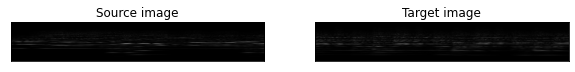

In [ ]:

fig = plt.figure(figsize=(10, 3))
model.eval()

x0, t = train_dataset[800]
x0_1= x0.to(device)
x0_1 = x0_1.view(-1,115*749*3)
y0, z0 = model(x0_1)
print(z0)
im = x0.view(-1, 3, 115, 749).permute(0, 2, 3, 1).cpu().squeeze().detach().numpy()
pil_img = Image.fromarray(np.uint8(im * 255))
pil_img.save("/content/result/source_img.bmp")
ax0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax0.set_title('Source image')
ax0.imshow(im, 'gray')

x1, t = train_dataset[1500]
x1_1=x1.to(device)
x1_1 = x1_1.view(-1,115*749*3)
y1, z1 = model(x1_1)
print(z1)
im = x1.view(-1, 3, 115, 749).permute(0,2,3,1).cpu().squeeze().detach().numpy()
pil_img = Image.fromarray(np.uint8(im * 255))
pil_img.save("/content/result/target_img.bmp")
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Target image')
ax1.imshow(im, 'gray')

In [ ]:
fig = plt.figure(figsize=(10, 3))
z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)])
z_linear = z_linear.view((10, -1))
y2 = model._decoder(z_linear).view(-1, 3, 115, 749).permute(0,2,3,1)
for i, im in enumerate(y2.cpu().detach().numpy()):
    pil_img = Image.fromarray(np.uint8(im * 255))
    pil_img.save("/content/result/morfhing_img_{}.bmp".format(i))
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')